# Using Haversine Distance Equation to find closest distance
###### https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546

In [18]:
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

import numpy as np
from geopy.geocoders import Nominatim
import pgeocode

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from math import radians, cos, sin, asin, sqrt

import sys 
sys.path.insert(0, '../config/')
from wallet import mapbox_token

import plotly.graph_objects as go

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import plotly.io as pio

# pio.renderers.default = "png"

In [19]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

## Replicating Haversine Distance fromula in Python :

In [3]:
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

## The above calculate the distance to all cancer centers. Using idxmin you can find the closest center NAME using the following function

In [4]:
def find_nearest(df, lat, long):
    distances = df.apply(
        lambda row: dist(lat, long, row['LAT'], row['LON']), 
        axis=1)
    return df.loc[distances.idxmin(), 'NAME']

In [5]:
cancer_df = pd.read_csv('cancer_df_new_coordinates.csv')
cancer_df = cancer_df.iloc[:,1:]
cancer_df.drop(columns = ['SCORE','RANKING','LATITUDE','LONGITUDE','NEW_COOR'], inplace = True)
cancer_df.head()

,NAME,AHA_ID,ZIP,STATE,RAW_SCORE,Percentile Rank,STAR,LAT,LON
0,University of Texas MD Anderson Cancer Center,6741945,77030,TX,100.0,1.000000,5,29.7041,-95.4010
1,Mayo Clinic,6610451,53821,WI,79.9,0.997222,5,43.0426,-91.1193
2,UCLA Medical Center,6931755,90095,CA,73.2,0.995833,5,33.7866,-118.2987
3,Cleveland Clinic,6410670,44333,OH,71.9,0.994444,5,41.1552,-81.6314
4,Cedars-Sinai Medical Center,6930444,90048,CA,67.7,0.993056,5,34.0737,-118.3720


# the following function to find coordinates from a zip code

In [6]:
def find_coordinates_from_zip(zip):
    nomi = pgeocode.Nominatim('us')
    query = nomi.query_postal_code(zip)
    return query["latitude"],query["longitude"]

Please insert your zip code:  94707


/var/folders/sv/sf850pgs5cvc4zsv0yyq1hhr0000gn/T/ipykernel_15206/4200505499.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



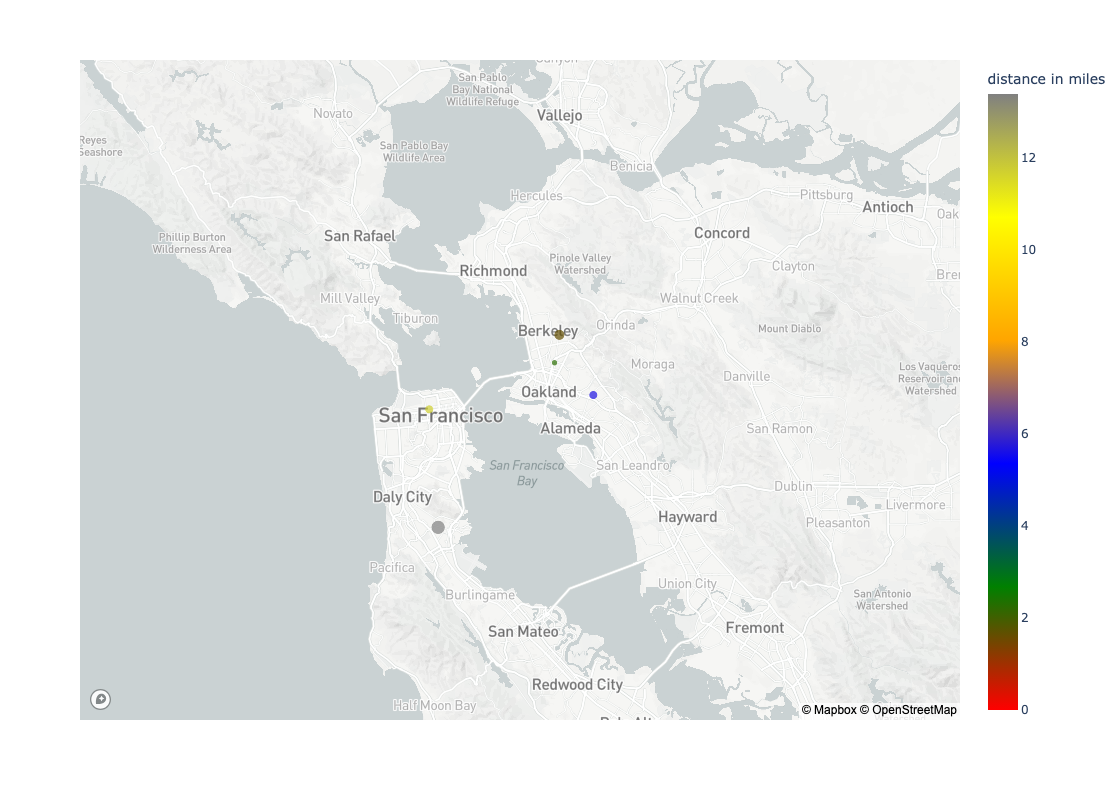

In [20]:
zip_input = str(input('Please insert your zip code: '))
# uc_berkeley_zip = '94720'

cancer_df['input_LAT'] = find_coordinates_from_zip(zip_input)[0]
cancer_df['input_LON'] = find_coordinates_from_zip(zip_input)[1]
cancer_df['distance'] = [dist(cancer_df.LON[i],cancer_df.LAT[i],cancer_df.input_LON[i],cancer_df.input_LAT[i]) for i in range(len(cancer_df))]
cancer_df['distance'] = cancer_df['distance'].round(decimals=3)
#convert KM to Mile
# conversion factor
conv_fac = 0.621371

# calculate miles
cancer_df['distance in miles'] = cancer_df['distance'] * conv_fac

#merge input location with the top 5 

# ['Your location',0,cancer_df['input_LAT'][0],cancer_df['input_LON'][0],0]

top5_nearest_location_df = cancer_df.sort_values(by = 'distance').head()[['NAME','STAR','LAT','LON','distance in miles']].append\
                            ({'NAME':'Your location',
                              'STAR':0,
                              'LAT':cancer_df['input_LAT'][0],
                              'LON':cancer_df['input_LON'][1],
                              'distance in miles':0},ignore_index=True)

top5_nearest_location_df = top5_nearest_location_df.sort_values(by = 'distance in miles')

# view in the map
px.set_mapbox_access_token(mapbox_token)
fig = px.scatter_mapbox(top5_nearest_location_df,
                  lat="LAT", lon="LON", color="distance in miles", size='STAR' ,
                   size_max=10, zoom=9, width=1200, height=800,color_continuous_scale=['red','green','blue','orange','yellow','gray'] )

fig.show()

In [21]:
top5_nearest_location_df

,NAME,STAR,LAT,LON,distance in miles
5,Your location,0,37.8927,-122.2761,0.000000
0,Alta Bates Summit Medical Center-Berkeley,3,37.8664,-122.2570,1.637934
1,Alta Bates Summit Medical Center-Oakland,1,37.8361,-122.2637,2.256819
2,Highland Hospital,2,37.8011,-122.2104,5.657583
3,California Pacific Medical Center,2,37.7856,-122.4358,11.723407
4,Kaiser Permanente San Francisco Medical Center,5,37.6574,-122.4235,13.393652


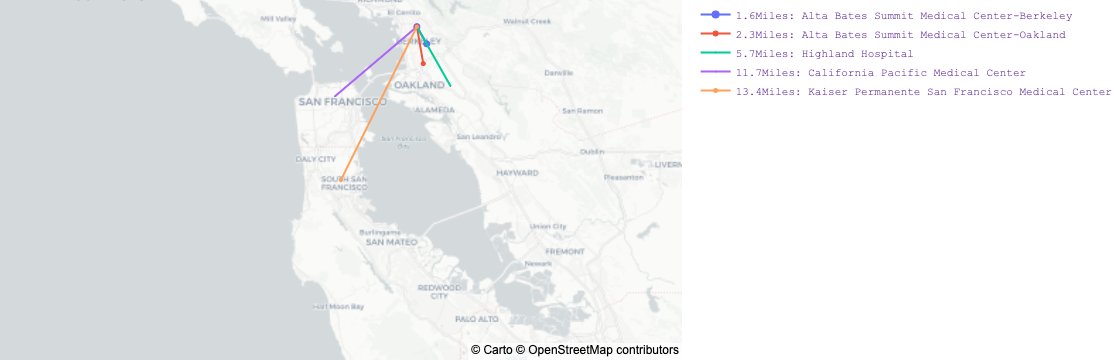

NameError: name 'py_offline' is not defined

In [62]:

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-122.2761, -122.2570],
    lat = [37.8927, 37.8664],
    marker = {'size': 8},
    name= "1.6Miles: Alta Bates Summit Medical Center-Berkeley",
    text=["Your location",
          "Alta Bates Summit Medical Center-Berkeley"],))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-122.2761, -122.2637],
    lat = [37.8927, 37.8361],
    marker = {'size': 6},
    name = "2.3Miles: Alta Bates Summit Medical Center-Oakland",
    text=["Your location",
          "Alta Bates Summit Medical Center-Oakland"],))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-122.2761, -122.2104],
    lat = [37.8927, 37.8011],
    marker = {'size': 2},
    name = "5.7Miles: Highland Hospital",
    text=["Your location",
          "Highland Hospital"],))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-122.2761, -122.4358],
    lat = [37.8927, 37.7856],
    marker = {'size': 2},
    name = "11.7Miles: California Pacific Medical Center",
    text=["Your location",
         "California Pacific Medical Center"],))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-122.2761, -122.4235],
    lat = [37.8927, 37.6574],
    marker = {'size': 5},
    name = "13.4Miles: Kaiser Permanente San Francisco Medical Center",
    text=["Your location",
          "Kaiser Permanente San Francisco Medical Center"],
))



fig.update_layout(
    
    autosize=True,
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        
        # 'center': {'lon': -122.2761	, 'lat': 37.8927},
        'style': "carto-positron",
        'center': {'lon': -122.4235, 'lat': 37.6574},
        'zoom': 8.5},
    title="Plot Title",
        font=dict(
            
        family="Courier New, monospace",
        size=11,
        color="RebeccaPurple"
    )
)


fig.show()
# fig.write_html("berkeley.html")
py_offline.iplot(fig)